## Time Series

* ***Sometimes in time series data, we have to adjust the frequency(interval size). If we have to increase interval size(eg daily data to monthly data), we have to aggregate the data by some measure. If we want to decrease interval size(eg monthly to daily), then we have to impute the missing data points.***

* ***Time series data distributions are unlike any other statistical distributions(like Normal distributions) as they do not follow Gauss-Markov assumptions. For example, it is violated as time series data has autocorrelation(degree of similarity between the time series and a lagged version of itself over successive intervals.***

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA
from scipy.stats import chi2

%matplotlib inline

***These are actually market indices:***

* ***spx:*** *S&P 500 (USA)*
* ***dax:*** *DAX 30 (GERMANY)*
* ***ftse:*** *FTSE 100 (LONDON)*
* ***nikkei:*** *NIKKEI 225 (Japan)*

***The numbers 500, 30, 100 and 225 denote the no. of companies involved in the market indices.***

In [2]:
actual_data = pd.read_csv("../../datasets/stock_prices/index_2018.csv")
df = actual_data.copy()
df.head()

,date,spx,dax,ftse,nikkei
0,07/01/1994,469.90,2224.95,3445.98,18124.01
1,10/01/1994,475.27,2225.00,3440.58,18443.44
2,11/01/1994,474.13,2228.10,3413.77,18485.25
3,12/01/1994,474.17,2182.06,3372.02,18793.88
4,13/01/1994,472.47,2142.37,3360.01,18577.26


In [3]:
df["date"] = pd.to_datetime(df["date"], dayfirst=True)
df_index = df["date"]
df.drop("date", axis=1, inplace=True)
df.index = df_index
df.index.name = None

In [4]:
df.head()

,spx,dax,ftse,nikkei
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


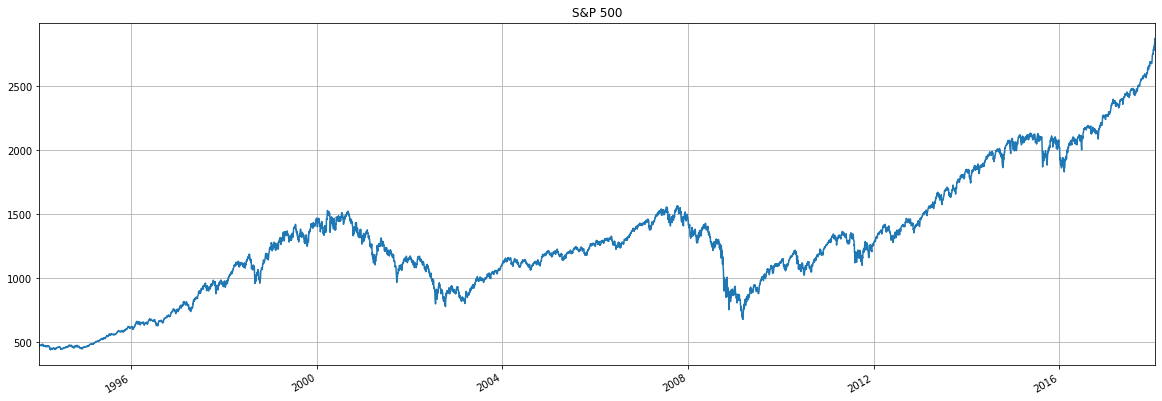

In [5]:
plt.figure(figsize=(20, 7))
df["spx"].plot(title="S&P 500")
plt.grid(True)
plt.show()

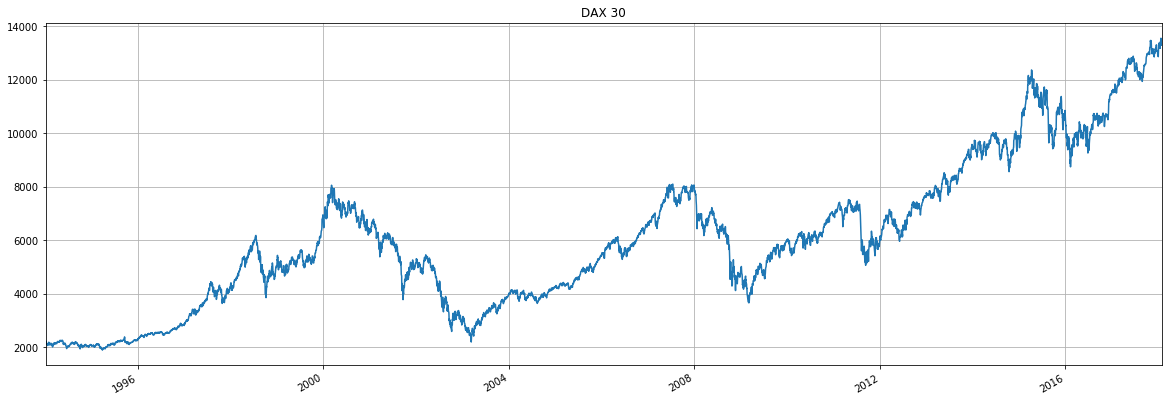

In [6]:
plt.figure(figsize=(20, 7))
df["dax"].plot(title="DAX 30")
plt.grid(True)
plt.show()

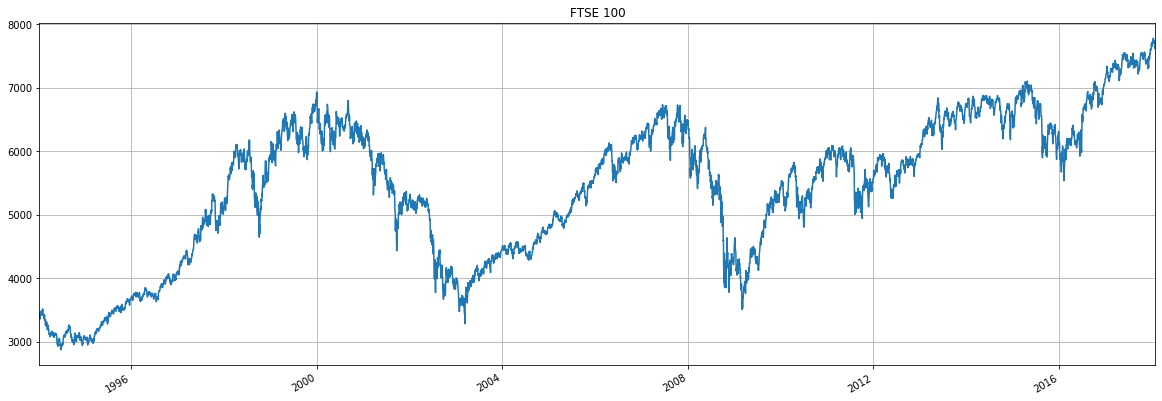

In [7]:
plt.figure(figsize=(20, 7))
df["ftse"].plot(title="FTSE 100")
plt.grid(True)
plt.show()

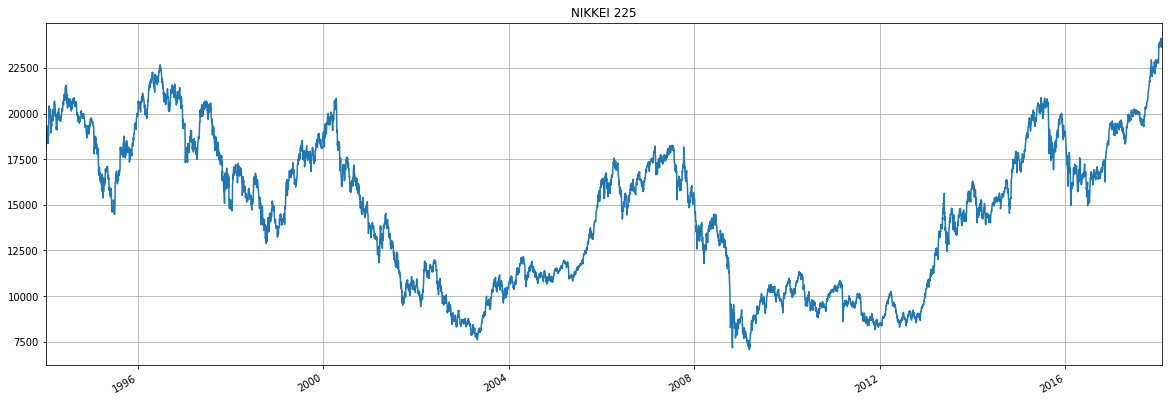

In [8]:
plt.figure(figsize=(20, 7))
df["nikkei"].plot(title="NIKKEI 225")
plt.grid(True)
plt.show()

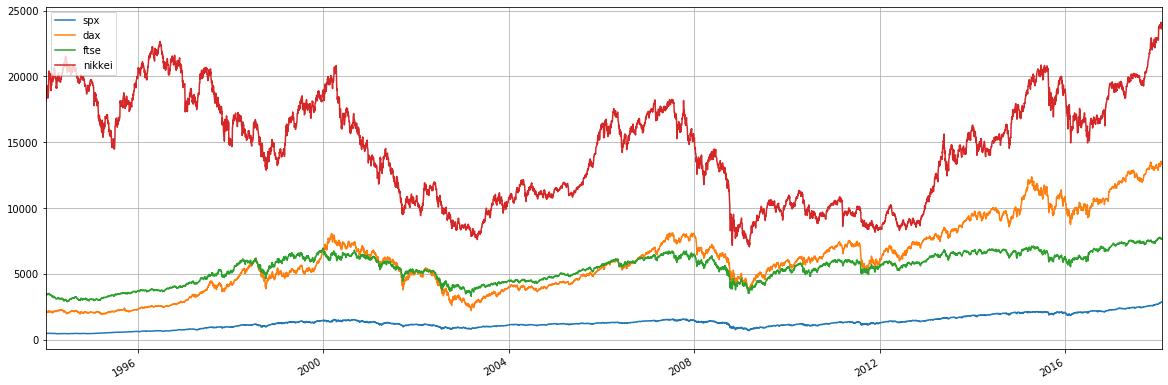

In [9]:
plt.figure(figsize=(20, 7))
df["spx"].plot()
df["dax"].plot()
df["ftse"].plot()
df["nikkei"].plot()
plt.grid(True)
plt.legend(loc="upper left")
plt.show()

***Change frequency to business days(doesn't include weekends), as these data points are recorded during business days only.***

In [10]:
df = df.asfreq("b")
df.head()

,spx,dax,ftse,nikkei
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


***Imputing values in time series***

* ***(i) Front fill:*** *Fill the previous value as the imputed value.*
* ***(ii) Back fill:*** *Fill the next value as the imputed value.*
* ***(iii) Mean impute***

In [11]:
df["spx"] = df["spx"].fillna(method="ffill")
df["dax"] = df["dax"].fillna(method="ffill")
df["ftse"] = df["ftse"].fillna(method="ffill")
df["nikkei"] = df["nikkei"].fillna(method="ffill")

In [12]:
df_spx = df["spx"]

***Splitting the data***

In [13]:
size = int(len(df_spx) * 0.8)
df_train = df_spx.iloc[:size]
df_test = df_spx.iloc[size:]

## The Autocorrelation function(ACF)

* ***x-axis represents lag and y-axis represents the autocorrelation coefficient value(between [-1, 1]). The different lines are the autocorrelation and the different lags of time series.***

* ***The blue line across the x-axis is called as the significance. All lags are significant here as they all are outside of the significance.***

* ***Another thing to notice here is that with increase in number of lags, the autocorrelation doesn't seem to decrease, meaning that they are very strongly correlated with the time series.***

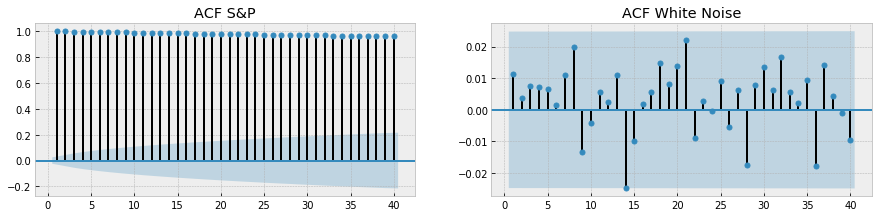

In [14]:
with plt.style.context("bmh"):
    layout = (2, 2)
    plt.figure(figsize=(15, 7))
    spx_ax = plt.subplot2grid(layout, (0, 0))
    wn_ax = plt.subplot2grid(layout, (0, 1))
    sgt.plot_acf(df["spx"], lags=40, unbiased=True, zero=False, ax=spx_ax, title="ACF S&P")
    sgt.plot_acf(np.random.normal(loc=df["spx"].mean(), scale=df["spx"].std(), size=len(df)), lags=40, unbiased=True, zero=False, ax=wn_ax, title="ACF White Noise")
    plt.grid(True)
    plt.show()

## The Partial Autocorrelation Function(PACF)

* ***ACF finds autocorrelation between the time series and the lagged version of itself, but autocorrelation for nth lag and the time series also includes the autocorrelation between nth lag and (n+1), (n+2), ... lags, which is not ideal.***

* ***In order to find direct correlation between the time series and the lagged version of itself and nothing else, use PACF.***

* ***One can also say that -ve autocorrelation means that higher values in that lagged version are smaller now.***

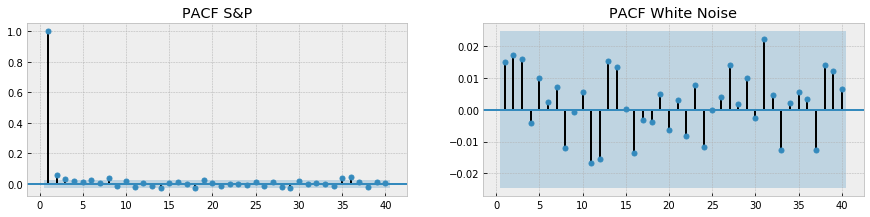

In [15]:
with plt.style.context("bmh"):
    layout = (2, 2)
    plt.figure(figsize=(15, 7))
    spx_ax = plt.subplot2grid(layout, (0, 0))
    wn_ax = plt.subplot2grid(layout, (0, 1))
    sgt.plot_pacf(df["spx"], lags=40, zero=False, method="ols", ax=spx_ax, title="PACF S&P")
    sgt.plot_pacf(np.random.normal(loc=df["spx"].mean(), scale=df["spx"].std(), size=len(df)), lags=40, zero=False, method="ols", ax=wn_ax, title="PACF White Noise")
    plt.grid(True)
    plt.show()

## AR model

* ***AR model is a linear model. Lags can be useless in determining current values if their autocorrelation coefficients are not significant.***

$$X(t) = \alpha + \theta_1 \cdot X(t - 1) + Er(t)$$

* ***First, we determine the number of lags, then apply the formula. For example, predictions using the AR model for the current value when the no. of lags are 2 is defined as:***

$$X(t) = \alpha + \theta_1 \cdot X(t - 1) + \theta_2 \cdot X(t - 2) + Er(t)$$

* ***We are looking for AR models with higher log-likelihood and small information criterion. If log-likelihood is negative, then the lower, the higher it is actually.***

In [16]:
df_ftse = pd.DataFrame(df["ftse"])

In [17]:
# (1, 0) -> (No. of past values we consider, 0 means no residuals/errors included)
# This is a Simple AR model or AR(1)
model_ar = ARMA(df_ftse["ftse"], order=(1, 0))

result_ar = model_ar.fit()

result_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   ftse   No. Observations:                 6277
Model:                     ARMA(1, 0)   Log Likelihood              -34438.042
Method:                       css-mle   S.D. of innovations             58.378
Date:                Sat, 14 Mar 2020   AIC                          68882.083
Time:                        14:18:02   BIC                          68902.317
Sample:                    01-07-1994   HQIC                         68889.094
                         - 01-29-2018                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5710.0065    756.262      7.550      0.000    4227.759    7192.254
ar.L1.ftse     0.9991      0.001   1616.910      0.000       0.998       1.000
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0009           +0.0000j            1.0009            0.0000
-----------------------------------------------------------------------------
"""

***Higher AR models***

In [18]:
model_ar_2 = ARMA(df_ftse, order=(2, 0))

result_ar_2 = model_ar_2.fit()

result_ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   ftse   No. Observations:                 6277
Model:                     ARMA(2, 0)   Log Likelihood              -34437.807
Method:                       css-mle   S.D. of innovations             58.376
Date:                Sat, 14 Mar 2020   AIC                          68883.613
Time:                        14:18:03   BIC                          68910.592
Sample:                    01-07-1994   HQIC                         68892.961
                         - 01-29-2018                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5706.5488    760.976      7.499      0.000    4215.062    7198.035
ar.L1.ftse     0.9905      0.013     78.806      0.000       0.966       1.015
ar.L2.ftse     0.0086      0.013      0.686      0.493      -0.016       0.033
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0009           +0.0000j            1.0009            0.0000
AR.2         -115.8762           +0.0000j          115.8762            0.5000
-----------------------------------------------------------------------------
"""

***As p-value(0.493) > 0.5(SL), null hypothesis is rejected and the coefficient for the 2nd lag isn't significantly different from zero, so we assume it to be zero.***

In [19]:
model_ar_3 = ARMA(df_ftse, order=(3, 0))

result_ar_3 = model_ar_3.fit()

result_ar_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   ftse   No. Observations:                 6277
Model:                     ARMA(3, 0)   Log Likelihood              -34430.772
Method:                       css-mle   S.D. of innovations             58.311
Date:                Sat, 14 Mar 2020   AIC                          68871.544
Time:                        14:18:04   BIC                          68905.267
Sample:                    01-07-1994   HQIC                         68883.228
                         - 01-29-2018                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5423.6802    707.440      7.667      0.000    4037.124    6810.236
ar.L1.ftse     0.9900      0.013     78.894      0.000       0.965       1.015
ar.L2.ftse    -0.0380      0.018     -2.149      0.032      -0.073      -0.003
ar.L3.ftse     0.0471      0.013      3.736      0.000       0.022       0.072
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0008           -0.0000j            1.0008           -0.0000
AR.2           -0.0967           -4.6042j            4.6052           -0.2533
AR.3           -0.0967           +4.6042j            4.6052            0.2533
-----------------------------------------------------------------------------
"""

In [20]:
model_ar_4 = ARMA(df_ftse, order=(4, 0))

result_ar_4 = model_ar_4.fit()

result_ar_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   ftse   No. Observations:                 6277
Model:                     ARMA(4, 0)   Log Likelihood              -34421.635
Method:                       css-mle   S.D. of innovations             58.226
Date:                Sat, 14 Mar 2020   AIC                          68855.270
Time:                        14:18:05   BIC                          68895.738
Sample:                    01-07-1994   HQIC                         68869.291
                         - 01-29-2018                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5423.6827    757.359      7.161      0.000    3939.286    6908.080
ar.L1.ftse     0.9875      0.013     78.870      0.000       0.963       1.012
ar.L2.ftse    -0.0360      0.018     -2.037      0.042      -0.071      -0.001
ar.L3.ftse    -0.0062      0.018     -0.353      0.724      -0.041       0.028
ar.L4.ftse     0.0539      0.013      4.278      0.000       0.029       0.079
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0007           -0.0000j            1.0007           -0.0000
AR.2            1.0305           -2.2864j            2.5079           -0.1826
AR.3            1.0305           +2.2864j            2.5079            0.1826
AR.4           -2.9459           -0.0000j            2.9459           -0.5000
-----------------------------------------------------------------------------
"""

## Log-likelihood Ratio(LLR) Test

***This test is used to determine whether or not the two AR models are significantly different.***

In [21]:
def LLR_test(model1, model2, df=1):
    """
        model1 -> First model
        model2 -> Second model
        df -> Degrees of freedom(default 1 as we are generally comparing models of only one order difference)
    """
    L1 = model1.fit().llf
    L2 = model2.fit().llf
    LR = 2 * (L2 - L1)
    p = chi2.sf(LR, df).round(4)
    return p

***LLR test on AR(2) and AR(3). p-value < SL(0.05), so null hypothesis is not rejected, and the differences are significant.***

In [22]:
LLR_test(ARMA(df_ftse, order=(2, 0)), ARMA(df_ftse, order=(3, 0)))

0.0002

***LLR test on AR(3) and AR(4). p-value < SL(0.05), so null hypothesis is not rejected, and the differences are significant.***

In [23]:
LLR_test(ARMA(df_ftse, order=(3, 0)), ARMA(df_ftse, order=(4, 0)))

0.0

***We have to go on until we find AR(n) such that the last lag of AR(n) is insignificant and its difference from AR(n-1) is also insignificant.***

In [24]:
model_ar_5 = ARMA(df_ftse, order=(5, 0))
result_ar_5 = model_ar_5.fit()
print(result_ar_5.summary())
print("LLR test p-value", LLR_test(ARMA(df_ftse, order=(4, 0)), ARMA(df_ftse, order=(5, 0))))

                              ARMA Model Results                              
Dep. Variable:                   ftse   No. Observations:                 6277
Model:                     ARMA(5, 0)   Log Likelihood              -34421.343
Method:                       css-mle   S.D. of innovations             58.223
Date:                Sat, 14 Mar 2020   AIC                          68856.685
Time:                        14:18:12   BIC                          68903.898
Sample:                    01-07-1994   HQIC                         68873.044
                         - 01-29-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5423.6802    748.101      7.250      0.000    3957.430    6889.931
ar.L1.ftse     0.9880      0.013     78.770      0.000       0.963       1.013
ar.L2.ftse    -0.0361      0.018     -2.040      0.0

***Hence, we stop at AR(4). Lets check with default AR model. And the results are significant.***

In [25]:
print("LLE test p-value:", LLR_test(ARMA(df_ftse, order=(1, 0)), ARMA(df_ftse, order=(4, 0)), df=3))

LLE test p-value: 0.0


***Dickey-Fuller Test***
* *Null hypothesis assumes non-stationarity(first lag coefficient is less than 1).*
* *If test-statistic > critical_value, null hypothesis rejected.*

* *(t-statistic, p-value, no_of_lags, len(data), critical value for different S.L, estimated maximum I.C)*

In [26]:
# t-statistic > critical_value. But p-value is not small enough. So, null hypothesis can't be rejected.
sts.adfuller(df_ftse["ftse"])

(-1.597778892117986,
 0.4847091205465961,
 6,
 6270,
 {'1%': -3.4313933778649943,
  '5%': -2.862001080749219,
  '10%': -2.567015430304048},
 68476.87620974617)

***Now that we know our data is non-stationary, we should transform it to a stationary one so as use AR models effectively. In finance, we can get stationarity by using returns instead of prices.***

* ***Returns:*** *Returns are defined as the percentage change between two consecutive periods.*
* *If forecasted returns are positive, then investor would want to keep his stock and vice-versa.*

***What we need to do can be defined by this formula:***

$$\dfrac{P(t) - P(t - 1)}{P(t - 1)} \cdot 100$$

In [27]:
df_ftse["returns"] = df_ftse["ftse"].pct_change(1)
df_ftse = df_ftse.iloc[1:]

In [28]:
sts.adfuller(df_ftse["returns"])

(-15.14076133203508,
 7.016338451087974e-28,
 34,
 6241,
 {'1%': -3.431398228116075,
  '5%': -2.8620032237533897,
  '10%': -2.5670165710764503},
 -38455.2297924369)

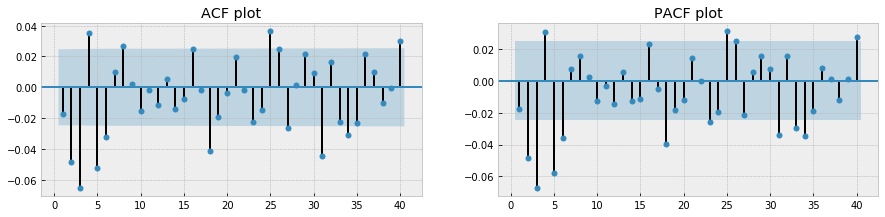

In [29]:
with plt.style.context("bmh"):
    layout = (2, 2)
    plt.figure(figsize=(15, 7))
    acf_ax = plt.subplot2grid(layout, (0, 0))
    pacf_ax = plt.subplot2grid(layout, (0, 1))
    sgt.plot_acf(df_ftse["returns"], lags=40, zero=False, unbiased=True, ax=acf_ax, title="ACF plot")
    sgt.plot_pacf(df_ftse["returns"], lags=40, zero=False, method="ols", ax=pacf_ax, title="PACF plot")
    plt.grid(True)
    plt.show()

***These plots indicate that returns for today move in the opposite direction to what they were yesterday or some days before.***

In [30]:
model_returns_ar_1 = ARMA(df_ftse["returns"], order=(1, 0))
result_returns_ar_1 = model_returns_ar_1.fit()
result_returns_ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 6276
Model:                     ARMA(1, 0)   Log Likelihood               19304.343
Method:                       css-mle   S.D. of innovations              0.011
Date:                Sat, 14 Mar 2020   AIC                         -38602.687
Time:                        14:18:20   BIC                         -38582.453
Sample:                    01-10-1994   HQIC                        -38595.676
                         - 01-29-2018                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0002      0.000      1.371      0.170   -8.16e-05       0.000
ar.L1.returns    -0.0176      0.013     -1.394      0.163      -0.042       0.007
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -56.8262           +0.0000j           56.8262            0.5000
-----------------------------------------------------------------------------
"""

In [31]:
model_returns_ar_2 = ARMA(df_ftse["returns"], order=(2, 0))
result_returns_ar_2 = model_returns_ar_2.fit()
print(result_returns_ar_2.summary())
print("LLR Test p-value: ", LLR_test(ARMA(df_ftse["returns"], order=(1, 0)), ARMA(df_ftse["returns"], order=(2, 0)), df=1))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 6276
Model:                     ARMA(2, 0)   Log Likelihood               19311.739
Method:                       css-mle   S.D. of innovations              0.011
Date:                Sat, 14 Mar 2020   AIC                         -38615.478
Time:                        14:18:20   BIC                         -38588.500
Sample:                    01-10-1994   HQIC                        -38606.131
                         - 01-29-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0002      0.000      1.440      0.150   -6.87e-05       0.000
ar.L1.returns    -0.0185      0.013     -1.464      0.143      -0.043       0.006
ar.L2.returns    -0.0485      0.013     

In [32]:
model_returns_ar_3 = ARMA(df_ftse["returns"], order=(3, 0))
result_returns_ar_3 = model_returns_ar_3.fit()
print(result_returns_ar_3.summary())
print("LLR Test p-value: ", LLR_test(ARMA(df_ftse["returns"], order=(2, 0)), ARMA(df_ftse["returns"], order=(3, 0)), df=1))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 6276
Model:                     ARMA(3, 0)   Log Likelihood               19326.097
Method:                       css-mle   S.D. of innovations              0.011
Date:                Sat, 14 Mar 2020   AIC                         -38642.194
Time:                        14:18:22   BIC                         -38608.472
Sample:                    01-10-1994   HQIC                        -38630.510
                         - 01-29-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0002      0.000      1.542      0.123   -5.16e-05       0.000
ar.L1.returns    -0.0217      0.013     -1.725      0.085      -0.046       0.003
ar.L2.returns    -0.0498      0.013     

In [33]:
model_returns_ar_4 = ARMA(df_ftse["returns"], order=(4, 0))
result_returns_ar_4 = model_returns_ar_4.fit()
print(result_returns_ar_4.summary())
print("LLR Test p-value: ", LLR_test(ARMA(df_ftse["returns"], order=(3, 0)), ARMA(df_ftse["returns"], order=(4, 0)), df=1))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 6276
Model:                     ARMA(4, 0)   Log Likelihood               19329.032
Method:                       css-mle   S.D. of innovations              0.011
Date:                Sat, 14 Mar 2020   AIC                         -38646.064
Time:                        14:18:23   BIC                         -38605.598
Sample:                    01-10-1994   HQIC                        -38632.043
                         - 01-29-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0002      0.000      1.494      0.135   -5.92e-05       0.000
ar.L1.returns    -0.0197      0.013     -1.559      0.119      -0.044       0.005
ar.L2.returns    -0.0482      0.013     

In [34]:
model_returns_ar_5 = ARMA(df_ftse["returns"], order=(5, 0))
result_returns_ar_5 = model_returns_ar_5.fit()
print(result_returns_ar_5.summary())
print("LLR Test p-value: ", LLR_test(ARMA(df_ftse["returns"], order=(4, 0)), ARMA(df_ftse["returns"], order=(5, 0)), df=1))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 6276
Model:                     ARMA(5, 0)   Log Likelihood               19339.506
Method:                       css-mle   S.D. of innovations              0.011
Date:                Sat, 14 Mar 2020   AIC                         -38665.013
Time:                        14:18:26   BIC                         -38617.801
Sample:                    01-10-1994   HQIC                        -38648.655
                         - 01-29-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0002      0.000      1.584      0.113   -4.51e-05       0.000
ar.L1.returns    -0.0179      0.013     -1.420      0.156      -0.043       0.007
ar.L2.returns    -0.0521      0.013     

In [35]:
model_returns_ar_6 = ARMA(df_ftse["returns"], order=(6, 0))
result_returns_ar_6 = model_returns_ar_6.fit()
print(result_returns_ar_6.summary())
print("LLR Test p-value: ", LLR_test(ARMA(df_ftse["returns"], order=(6, 0)), ARMA(df_ftse["returns"], order=(6, 0)), df=1))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 6276
Model:                     ARMA(6, 0)   Log Likelihood               19343.584
Method:                       css-mle   S.D. of innovations              0.011
Date:                Sat, 14 Mar 2020   AIC                         -38671.168
Time:                        14:18:29   BIC                         -38617.212
Sample:                    01-10-1994   HQIC                        -38652.473
                         - 01-29-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0002      0.000      1.643      0.100   -3.67e-05       0.000
ar.L1.returns    -0.0200      0.013     -1.584      0.113      -0.045       0.005
ar.L2.returns    -0.0510      0.013     

## Normalizing values

* ***We normalize values, so that gains or losses between different time series are comparable, as they are represented in percentages.***

In [40]:
benchmark = df_ftse["ftse"].iloc[0]
df_ftse["norm_prices"] = (df_ftse["ftse"] / benchmark) * 100
sts.adfuller(df_ftse["norm_prices"])

C:\Users\Hritik\AppData\Local\Continuum\anaconda3\envs\my_env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(-1.5870996932043748,
 0.4900704664016585,
 6,
 6269,
 {'1%': -3.4313935443677157,
  '5%': -2.8620011543157835,
  '10%': -2.5670154694652805},
 -33178.97072289408)

In [41]:
benchmark = df_ftse["returns"].iloc[0]
df_ftse["norm_returns"] = (df_ftse["returns"] / benchmark) * 100
sts.adfuller(df_ftse["norm_returns"])

C:\Users\Hritik\AppData\Local\Continuum\anaconda3\envs\my_env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(-15.140761332034936,
 7.01633845109119e-28,
 34,
 6241,
 {'1%': -3.431398228116075,
  '5%': -2.8620032237533897,
  '10%': -2.5670165710764503},
 42160.57428956767)

In [42]:
# model_returns_ar_6 = ARMA(df_ftse["returns"], order=(6, 0))
# result_returns_ar_6 = model_returns_ar_6.fit()
# print(result_returns_ar_6.summary())
# print("LLR Test p-value: ", LLR_test(ARMA(df_ftse["returns"], order=(6, 0)), ARMA(df_ftse["returns"], order=(6, 0)), df=1))

***In this case, normalized returns won't impact the forecasting results.***

***AR models are not that good at handling unexpected shocks in data, as they predict the current value using the previous values. Moving Average(MA) models take into account the residuals(errors) to predict the current value, so it is able to handle unexpected shocks more quickly.***